# Utilizing Mobile Positioning Data (MPD) to Measure SDGs Indicator 17.8.1: Proportion of Individuals Using the Internet

## Summary

`SDG Indicator 17.8.1` aims to assess the proportion of individuals using the Internet, specifically those who have accessed it within the last three months. The Internet, being a global computer network that facilitates various communication services like the World Wide Web, email, news, and entertainment, can be accessed through different devices such as computers, mobile phones, tablets, PDAs, gaming consoles, and digital TVs. Connectivity may be established through fixed or mobile networks.

Leveraging mobile phone data offers a valuable avenue for estimating and enhancing the measurement of this indicator. The utilization of mobile phone data can significantly contribute to the accurate and detailed assessment of SDG Indicator 17.8.1 by providing real-time and granular information on Internet usage. However, it is essential to approach data privacy, data quality, and the need for complementary data sources with careful consideration to ensure the reliability and effectiveness of the measurement process.

When feasible, the indicator can be further analyzed by various breakdowns and disaggregation criteria, such as regional distinctions (urban and rural areas), gender, age groups, etc. The International Telecommunication Union (ITU) collects data from countries encompassing these breakdowns to enhance the comprehensiveness of the indicator's assessment.

## Calculation of Indicator

### add highlight for hashing consistency from MNO

To obtain geographical coordinates and facilitate data aggregation, it is essential to combine Mobile Positioning Data (MPD) with cell data obtained from Mobile Network Operators (MNOs) or other publicly available sources. The cell data includes approximate geographical coordinates and the corresponding technology used. Each cell's location, categorized as the subscriber's home location, is then aggregated at the desired geographical level, such as LAU 2, and separated based on the technology used for internet connectivity.

The following assumptions are made regarding subscriber internet usage:

- If a subscriber has no mobile internet traffic (IPDR), it is assumed that they do not have internet access.
- If a subscriber only has mobile internet traffic in 2G cells (without any events in 3G or 4G), it is presumed that they solely use the internet through 2G.
- If a subscriber has any mobile internet traffic in 3G cells (potentially in 2G as well, but not in 4G), it is inferred that they use the internet through 3G.
- If a subscriber has any mobile internet traffic in 4G cells (and may also have usage in 2G and 3G), it is deduced that they utilize 4G for internet connectivity.

The resulting dataset contains the following fields:

- Level of aggregation, which can be demographic variables like gender and age group, administrative area, or a combination of them.
- total_home_count: number of persons with detected homes.
- no_data_home_count: number of subscribers who have no mobile internet traffic and have detected homes.
- 2G_home_count (2G): number of subscribers who have 2G mobile data traffic and a detected home.
- 3G_home_count (3G): number of subscribers who have 3G mobile data traffic and a detected home.
- 4G_home_count (4G): number of subscribers who have 4G data traffic and a detected home.

The resulting table will show the proportion of subscribers using the internet by technology in each group. To extrapolate this information to the rest of the population, additional data on mobile access is required. Since the MNO was also asked to indicate the cell type (2G, 3G, or 4G), the geographical distribution should be checked by cell type through visual analysis.

## Steps for Measurement
1. **Define the Scope of Aggregation**: Determine the geographic level (global, regional, national, or local) and specify the partnerships or initiatives to be considered for measurement.
2. **Identify Data Sources**: Join information from anchoring process with another data source like Customer relationship management (CRM) data that containing information about subscribers demography, and other data relevant data sources.
3. **Calculate the Indicator**: Use the formula below to calculate the indicator:
   ```
   Indicator 17.8.1 = (Number of individuals using the internet / Total number of individuals in the target population) x 100%
   ```
4. **Data Validation**: Validate the accuracy and reliability of the proxy indicator from mobile data by comparing it with other source including conventional survey to ensure its quality and coherence.

In [1]:
# Import the sys module to adjust the Python system path
import sys

# Append a path to the system path so that Python can import modules from the specified directory (relative path)
sys.path.append('../')

# Import the CONF, QA_summary and QA_action_plan variables from the script.QA module
from script.conf import *

In [2]:
# Import the os module to interact with the operating system
import os

# Try to create a new directory at the path QA_PATH using os.mkdir()
# If the directory already exists, print a message stating that it does
try:
    os.mkdir(INDICATOR_PATH)
    print("Create new folder {}".format(INDICATOR_PATH))
except FileExistsError:
    print("Folder {} already exists".format(INDICATOR_PATH))

Folder ../data/04_Indicator/ already exists


In [1]:
# Import the os module to interact with the operating system
import os

# Import Pandas module
import pandas as pd

# Import the PySpark module
import pyspark

# Import the Seaborn module
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_color_codes("pastel")

In [40]:
import pyspark.sql.functions as f
from pyspark.sql.functions import year, month, dayofmonth, substring, col, floor, expr, when, mean, count
from pyspark.sql.window import Window

# Import the SparkSession from PySpark
from pyspark.sql import SparkSession

# Create a SparkSession with the specified configuration
spark = SparkSession.builder\
        .master("local[{}]".format(CORE))\
        .appName("02.ITU.PySpark-Indicator")\
        .config('spark.sql.execution.arrow.pyspark.enabled', 'true')\
        .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'true')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Print the spark object which contains the SparkSession
spark

In [ ]:
# Use this code below to connect your remote spark cluster instead.

# # Import the PySpark module
# import pyspark
# from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType

# import pyspark.sql.functions as f
# from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
# from pyspark.sql.window import Window

# # Import the SparkSession from PySpark
# from pyspark.sql import SparkSession

# CLUSTER_URL = "spark://master"
# PORT = "7077"

# # Create a SparkSession with the specified configuration remote server
# spark = SparkSession.builder\
#         .master("{}:{}".format(CLUSTER_URL,PORT))\
#         .appName("01.ITU.PySpark-Raw")\
#         .getOrCreate()

# # Print the spark object which contains the SparkSession
# spark

In [4]:
# Set the path to the cell administrative location file. In this example, we will use data generated from QA step
# This is mandatory file that will be needed for indicator aggregation
path_cell = QA_PATH+'5_cell_administrative_location.csv'

# Read the cell administrative location file using Spark
cell = spark.read.format('csv')\
    .options(delimiter='\t',inferSchema="true")\
    .option('header',True)\
    .load(path_cell)

# Rename the 'cell_id' column to 'anchor_cell_id'
cell = cell.withColumnRenamed('cell_id','anchor_cell_id')
cell.show(5)

+--------------+--------+---------+--------------+
|anchor_cell_id|latitude|longitude|  municipality|
+--------------+--------+---------+--------------+
|            38|-22.8395| -43.3148|RIO DE JANEIRO|
|            82|-22.9176|   -43.43|RIO DE JANEIRO|
|            96|-23.0839| -43.7357| Out-of-bounds|
|            54|-22.9723| -43.3108|RIO DE JANEIRO|
|            13|-22.9145| -43.7425|RIO DE JANEIRO|
+--------------+--------+---------+--------------+
only showing top 5 rows



In [5]:
# Set the path to the zone file
path_zone = BASE_PATH+INDICATOR_ZONE_PATH

if os.path.exists(path=path_zone):
    ZONE_FLAG = True
    # Read the zone file using Spark
    zone = spark.read.format('csv')\
        .options(delimiter='\t',inferSchema="true")\
        .option('header',True)\
        .load(path_zone)

    # Rename the 'cell_id' column to 'anchor_cell_id'
    zone = zone.withColumnRenamed('cell_id','anchor_cell_id')
    zone.show(5)
else:
    ZONE_FLAG = False
    print("Information about ZONAL CLASSIFICATION (Urban, Rural) of the cell location is missing.")

+--------------+-------------------+
|anchor_cell_id|zone_classification|
+--------------+-------------------+
|            86|              URBAN|
|            71|              URBAN|
|            18|              RURAL|
|            59|              RURAL|
|           100|              RURAL|
+--------------+-------------------+
only showing top 5 rows



In [6]:
# Set the path to the CRM file
path_crm = BASE_PATH+INDICATOR_CRM_PATH

if os.path.exists(path=path_crm):
    CRM_FLAG = True
    # Read the CRM file using Spark
    crm = spark.read.format('csv')\
        .options(delimiter='\t',inferSchema="true")\
        .option('header',True)\
        .load(path_crm)

    # Create a new column 'age_group' by concatenating the age range
    crm = crm.withColumn('age_group',expr("concat(floor(age / 10) * 10, '-', floor(age / 10) * 10 + 10)"))

    # Show the contents of the CRM DataFrame
    crm.show()
else:
    CRM_FLAG = False
    print("Information about CUSTOMER RELATIONSHIP MANAGEMENT (Gender, Age Group) of the subscribers is missing.")

23/07/09 23:33:44 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Young Generation), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
23/07/09 23:33:44 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC, G1 Young Generation), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------+------+---+---------+
|       msisdn|gender|age|age_group|
+-------------+------+---+---------+
| subscriber_1|FEMALE| 43|    40-50|
| subscriber_2|FEMALE| 12|    10-20|
| subscriber_3|FEMALE| 54|    50-60|
| subscriber_4|FEMALE| 53|    50-60|
| subscriber_5|FEMALE| 57|    50-60|
| subscriber_6|  MALE|  9|     0-10|
| subscriber_7|  MALE| 95|   90-100|
| subscriber_8|FEMALE| 81|    80-90|
| subscriber_9|FEMALE| 48|    40-50|
|subscriber_10|  MALE| 95|   90-100|
|subscriber_11|  MALE| 38|    30-40|
|subscriber_12|  MALE| 90|   90-100|
|subscriber_13|  MALE| 93|   90-100|
|subscriber_14|  MALE| 21|    20-30|
|subscriber_15|FEMALE| 94|   90-100|
|subscriber_16|  MALE| 50|    50-60|
|subscriber_17|  MALE| 80|    80-90|
|subscriber_18|  MALE| 71|    70-80|
|subscriber_19|  MALE| 21|    20-30|
|subscriber_20|  MALE| 41|    40-50|
+-------------+------+---+---------+
only showing top 20 rows



In [7]:
# Set the path to the user anchor final file
path = ANCHOR_PATH+'user_anchor_final.csv'

# Read the user anchor final file using Spark, specifying the file format as CSV and setting the delimiter as tab. It also infers the schema from the data and treats the first row as the header.
df = spark.read.format('csv')\
    .options(delimiter='\t',inferSchema="true")\
    .option('header',True)\
    .load(path)

# Filter out rows where the 'anchor_cell_id' column is null
df = df.filter(col('anchor_cell_id').isNotNull())

# Join the df DataFrame with the cell DataFrame on the 'anchor_cell_id' column, using a left join
df = df.join(cell,['anchor_cell_id'],how='left')

if ZONE_FLAG:
    # Join the df DataFrame with the zone DataFrame on the 'anchor_cell_id' column, using a left join
    df = df.join(zone,['anchor_cell_id'],how='left')


if CRM_FLAG:
    # Join the df DataFrame with the crm DataFrame on the 'msisdn' column, using a left join
    df = df.join(crm,['msisdn'],how='left')

df.cache()

# Show the contents of the df DataFrame
df.show()

+-------------+--------------+-------------+-----------+----------+---------+--------+---------+--------+----------------+-----------------+--------------------+-----------+--------------+--------+---------+------------------+-------------------+------+---+---------+
|       msisdn|anchor_cell_id|internet_user|IPDR_events|CDR_events|IPDR_cell|CDR_cell|IPDR_date|CDR_date|CDR_main_service|IPDR_main_service|IPDR_highest_service|anchor_type|  anchor_label|latitude|longitude|      municipality|zone_classification|gender|age|age_group|
+-------------+--------------+-------------+-----------+----------+---------+--------+---------+--------+----------------+-----------------+--------------------+-----------+--------------+--------+---------+------------------+-------------------+------+---+---------+
|subscriber_10|            35|         true|        180|       147|       29|      29|        6|       6|              2G|               3G|                  4G|   ANCHOR_1|        DIRECT|-23.0177

In [8]:
df.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- anchor_cell_id: integer (nullable = true)
 |-- internet_user: boolean (nullable = true)
 |-- IPDR_events: integer (nullable = true)
 |-- CDR_events: integer (nullable = true)
 |-- IPDR_cell: integer (nullable = true)
 |-- CDR_cell: integer (nullable = true)
 |-- IPDR_date: integer (nullable = true)
 |-- CDR_date: integer (nullable = true)
 |-- CDR_main_service: string (nullable = true)
 |-- IPDR_main_service: string (nullable = true)
 |-- IPDR_highest_service: string (nullable = true)
 |-- anchor_type: string (nullable = true)
 |-- anchor_label: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- municipality: string (nullable = true)
 |-- zone_classification: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)



The code starts by defining a variable `tech_col` with the value 'IPDR_highest_service'.

Then, it uses the `groupBy()` function on a DataFrame `df` to group the data by the 'municipality' column.

After that, it calls the `agg()` function to perform multiple aggregation operations on the grouped data. Each aggregation operation is specified as a separate argument to the `agg()` function.

Here are the aggregation operations being performed:

1. `count(col('msisdn')).alias('total_home_count')`: This counts the number of rows in each group and assigns the alias 'total_home_count' to the resulting column.

2. `count(when(col('internet_user')==False,col('msisdn'))).alias('total_no_internet')`: This counts the number of rows where the 'internet_user' column is False, and assigns the alias 'total_no_internet' to the resulting column.

3. `count(when((col('internet_user')==True) & (col(tech_col)=='2G'),col('msisdn'))).alias('total_internet_2G')`: This counts the number of rows where the 'internet_user' column is True and the 'IPDR_highest_service' column is '2G', and assigns the alias 'total_internet_2G' to the resulting column.

4. `count(when((col('internet_user')==True) & (col(tech_col)=='3G'),col('msisdn'))).alias('total_internet_3G')`: This counts the number of rows where the 'internet_user' column is True and the 'IPDR_highest_service' column is '3G', and assigns the alias 'total_internet_3G' to the resulting column.

5. `count(when((col('internet_user')==True) & (col(tech_col)=='4G'),col('msisdn'))).alias('total_internet_4G')`: This counts the number of rows where the 'internet_user' column is True and the 'IPDR_highest_service' column is '4G', and assigns the alias 'total_internet_4G' to the resulting column.

In [28]:
# Define the column name to be used in the aggregation
tech_col = 'IPDR_highest_service'

# Group the dataframe 'df' by the 'municipality' column and perform aggregations
ind_adm = df.groupBy(['municipality']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['municipality']).toPandas()
ind_adm


,municipality,total_home_count,total_no_internet,total_internet_ALL,total_internet_2G,total_internet_3G,total_internet_4G
0,ITAGUAÍ,3,0,3,0,0,3
1,MESQUITA,3,0,3,0,0,3
2,NILÓPOLIS,1,0,1,0,0,1
3,NITERÓI,1,0,1,0,0,1
4,NOVA IGUAÇU,1,0,1,0,0,1
5,Out-of-bounds,20,0,20,0,0,20
6,RIO DE JANEIRO,28,0,28,0,0,28
7,SEROPÉDICA,7,0,7,0,0,7
8,SÃO JOÃO DE MERITI,2,0,2,0,0,2


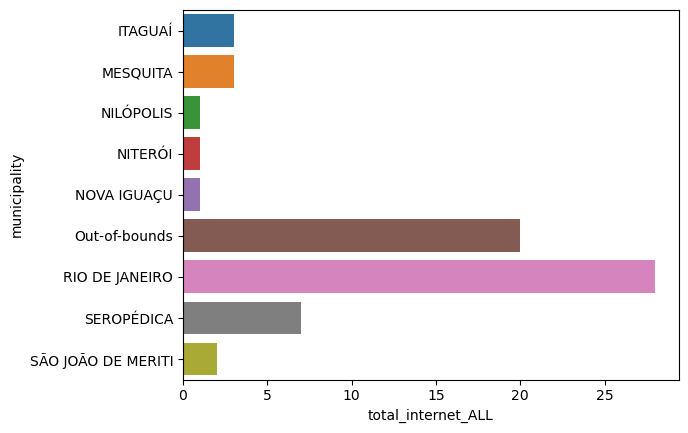

In [29]:
sns.barplot(data=ind_adm,y='municipality',x='total_internet_ALL',orient='h')

In [30]:
ind_adm.to_csv(INDICATOR_PATH+"ind_adm.csv",sep="\t",index=False)

In [31]:
# Check if ZONE_FLAG is True
if ZONE_FLAG:
    # If ZONE_FLAG is True, group the dataframe 'df' by 'zone_classification' and perform aggregations
    ind_zone = df.groupBy(['zone_classification']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['zone_classification']).toPandas()
    ind_zone.to_csv(INDICATOR_PATH+"ind_zone.csv",sep="\t",index=False)

    # Group the dataframe 'df' by both 'municipality' and 'zone_classification', and perform aggregations
    ind_adm_zone = df.groupBy(['municipality','zone_classification']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['municipality','zone_classification']).toPandas()
    ind_adm_zone.to_csv(INDICATOR_PATH+"ind_adm_zone.csv",sep="\t",index=False)

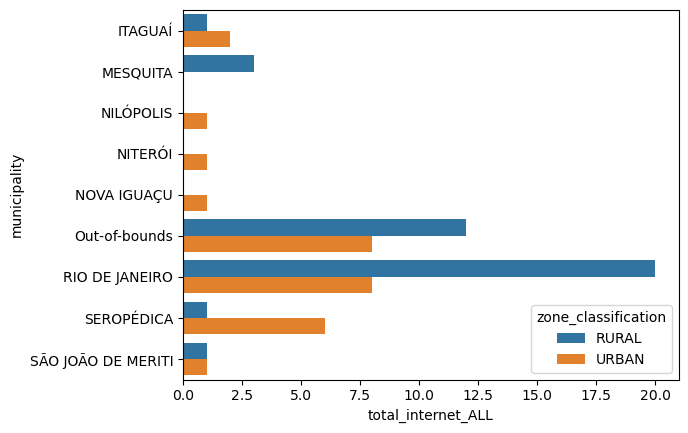

In [47]:
sns.barplot(
    data=ind_adm_zone,
    y='municipality',
    hue='zone_classification',
    x='total_internet_ALL',
    orient='h')

In [50]:
# Check if CRM_FLAG is True
if CRM_FLAG:
    # If CRM_FLAG is True, group the dataframe 'df' by 'age_group' and perform aggregations
    ind_age = df.groupBy(['age_group']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['age_group']).toPandas()
    # Convert the resulting dataframe to a Pandas DataFrame
    # Save the Pandas DataFrame to a CSV file with the name 'ind_age.csv' at the specified path 'INDICATOR_PATH', using tab as the separator and excluding the index column
    ind_age.to_csv(INDICATOR_PATH+"ind_age.csv", sep="\t", index=False)

    # Group the dataframe 'df' by 'gender' and perform aggregations
    ind_gen = df.groupBy(['gender']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['gender']).toPandas()
    # Convert the resulting dataframe to a Pandas DataFrame
    # Save the Pandas DataFrame to a CSV file with the name 'ind_gen.csv' at the specified path 'INDICATOR_PATH', using tab as the separator and excluding the index column
    ind_gen.to_csv(INDICATOR_PATH+"ind_gen.csv", sep="\t", index=False)
    
    # Group the dataframe 'df' by 'gender' and 'age_group' columns and perform aggregations
    ind_gen_age = df.groupBy(['gender', 'age_group']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['age_group', 'gender']).toPandas()
    # Convert the resulting dataframe to a Pandas DataFrame
    # Save the Pandas DataFrame to a CSV file named 'ind_gen_age.csv' at the specified path 'INDICATOR_PATH', using tab as the separator and excluding the index column
    ind_gen_age.to_csv(INDICATOR_PATH+"ind_gen_age.csv", sep="\t", index=False)
 
    # Group the dataframe 'df' by 'municipality', 'gender', and 'age_group' columns and perform aggregations
    ind_adm_gen_age = df.groupBy(['municipality', 'gender', 'age_group']).agg(
        count(col('msisdn')).alias('total_home_count'),  # Count the number of 'msisdn' values and alias the column as 'total_home_count'
        count(when(col('internet_user')==False, col('msisdn'))).alias('total_no_internet'),  # Count the number of 'msisdn' values where 'internet_user' is False and alias the column as 'total_no_internet'
        count(when(col('internet_user')==True, col('msisdn'))).alias('total_internet_ALL'),  # Count the number of 'msisdn' values where 'internet_user' is True, and alias the column as 'total_internet_ALL'
        count(when((col('internet_user')==True) & (col(tech_col)=='2G'), col('msisdn'))).alias('total_internet_2G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '2G', and alias the column as 'total_internet_2G'
        count(when((col('internet_user')==True) & (col(tech_col)=='3G'), col('msisdn'))).alias('total_internet_3G'),  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '3G', and alias the column as 'total_internet_3G'
        count(when((col('internet_user')==True) & (col(tech_col)=='4G'), col('msisdn'))).alias('total_internet_4G')  # Count the number of 'msisdn' values where 'internet_user' is True and 'tech_col' is '4G', and alias the column as 'total_internet_4G'
    ).orderBy(['municipality', 'age_group', 'gender']).toPandas()
    # Convert the resulting dataframe to a Pandas DataFrame
    # Save the Pandas DataFrame to a CSV file named 'ind_adm_gen_age.csv' at the specified path 'INDICATOR_PATH', using tab as the separator and excluding the index column
    ind_adm_gen_age.to_csv(INDICATOR_PATH+"ind_adm_gen_age.csv", sep="\t", index=False)

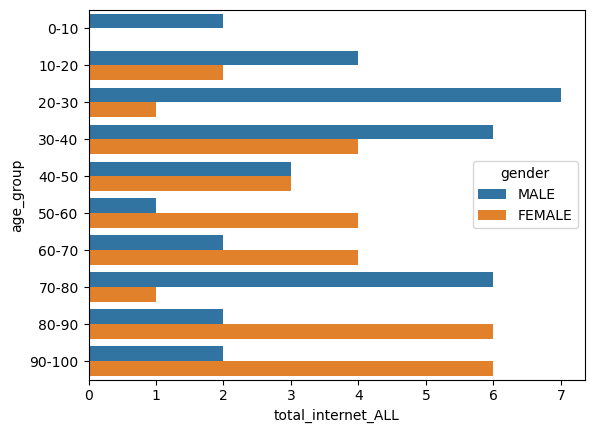

In [51]:
sns.barplot(
    data=ind_gen_age,
    y='age_group',
    hue='gender',
    x='total_internet_ALL',
    orient='h')